In [2]:
import numpy as np
import pynq_dpu
import matplotlib.pyplot as plt
import scipy.ndimage
import time
import cv2
from IPython.display import display, Image
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as R

image_size = (320, 240)

class NetworkDPU:
    
    def __init__(self, xmodel_path: str = 'SuperPointNet_soft_480.xmodel', dpu_path: str = 'dpu.bit'):

        self.ov: pynq_dpu.DpuOverlay = pynq_dpu.DpuOverlay(dpu_path, download=True)

        self.ov.load_model(xmodel_path)

        self.dpu = self.ov.runner
        print(self.ov.runner)
        inputTensors = self.dpu.get_input_tensors()
        outputTensors = self.dpu.get_output_tensors()
        # get list of shapes
        shapeIn = np.array([it.dims for it in inputTensors])
        shapeOut = np.array([ot.dims for ot in outputTensors])
        self.shapeIn = shapeIn
        self.shapeOut = shapeOut
        self.buff_in = [np.zeros(sh, np.int8, order='C') for sh in shapeIn]
        self.buff_out = [np.zeros(sh, np.int8, order='C') for sh in shapeOut]
        self.input_repr = [(it.get_attr('bit_width'), it.get_attr('fix_point')) for it in inputTensors]
        self.output_repr = [(ot.get_attr('bit_width'), ot.get_attr('fix_point')) for ot in outputTensors]
        
    def input_float_to_int8(self, x: np.ndarray) -> np.ndarray:
        BIT_WIDTH, PRECISION_BITS = self.input_repr[0]
        x = x * (2**PRECISION_BITS)
        x = np.floor(x)
        x = np.clip(x,-128, 127)
        return x.astype(np.int8)
    
    def output_int8_to_float(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[0]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y * PRECISION
        return y.astype(np.float32)
    
    def output_int8_to_float_2(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[1]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y * PRECISION
        return y.astype(np.float32)
    
    def process(self, x: np.ndarray):
        x = self.input_float_to_int8(x)
        self.buff_in[0] = x
        # start DPU threat
        job_id = self.dpu.execute_async(self.buff_in, self.buff_out)
        self.dpu.wait(job_id)
        scores = self.buff_out[1]
        scores = self.output_int8_to_float_2(scores)
        descriptors_dense = self.buff_out[0]

        descriptors_dense = self.output_int8_to_float(descriptors_dense)
        scores = scores[:, :, :, :-1]
        b, h, w, _ = scores.shape
        scores = scores.reshape(b, h, w, 8, 8)
        scores = scores.transpose(0, 1, 3, 2, 4).reshape(b, h * 8, w * 8)
        return scores, descriptors_dense
    
    def __call__(self, x: np.ndarray):
        return self.process(x)
    
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """
    Interpolates descriptors at keypoint locations.
    """
    h, w, c = descriptors.shape
    keypoints = (keypoints + 0.5) / (np.array([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalizacja do zakresu (-1, 1)

    num_keypoints = keypoints.shape[0]
    sampled_descriptors = np.zeros((num_keypoints, c), dtype=descriptors.dtype)
    x = ((keypoints[:, 0] + 1) / 2) * (w - 1)
    y = ((keypoints[:, 1] + 1) / 2) * (h - 1)
    for ch in range(c):
        sampled_descriptors[:, ch] = scipy.ndimage.map_coordinates(
            descriptors[:,:,ch], [[y], [x]], order=1, mode='nearest')

    norms = np.linalg.norm(sampled_descriptors, axis=1, keepdims=True)
    descriptors_normalized = sampled_descriptors / (norms + 1e-6)
    return descriptors_normalized

def nms(scores, nms_radius: int):
    """Performs non-maximum suppression (NMS) on a dense score map using max pooling."""
    assert nms_radius >= 0

    def max_pool(x, size):
        return scipy.ndimage.maximum_filter(x, size=size, mode='constant', cval=0.0)

    max_mask = scores == max_pool(scores, nms_radius * 2 + 1)
    suppressed_scores = np.where(max_mask, scores, 0)
    return suppressed_scores

def post_processing(scores, descriptors_dense, nms_radius=5, score_threshold=0.005, s=8):
    """Processes correlation maps and dense descriptors to obtain keypoints and their descriptors."""
    scores = nms(scores, nms_radius)
    pad = 4
    scores[:pad] = -1
    scores[:, :pad] = -1
    scores[-pad:] = -1
    scores[:, -pad:] = -1
    idxs = np.where(scores > score_threshold)
    keypoints = np.stack(idxs[::-1], axis=-1).astype(float)
    scores_all = scores[idxs]

    norms = np.linalg.norm(descriptors_dense, axis=0, keepdims=True)
    descriptors_dense = descriptors_dense / (norms + 1e-6)
    indices = np.argsort(scores_all)[::-1] 
    indices = indices[:300]
    keypoints_top = keypoints[indices]

    descriptors = sample_descriptors(keypoints, descriptors_dense, s)

    return keypoints, descriptors


def match_descriptors(kp1, desc1, kp2, desc2):
    """Match the keypoints with the warped_keypoints with nearest neighbor search"""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]
    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    """Estimate the homography between the matches using RANSAC"""
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def match_points(scores1, descriptors1, scores2, descriptors2):
    keypoints1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores1]
    keypoints2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores2]
    m_kp1, m_kp2, matches = match_descriptors(keypoints1, descriptors1, keypoints2, descriptors2)
    H, inliers = compute_homography(m_kp1, m_kp2)
    matches = np.array(matches)[inliers.astype(bool)].tolist()

    return matches, keypoints1, keypoints2

def pose_estimation(points1, points2, t_total, R_total, abs_scale, focal=525.0, pp=(319.5, 239.5)):
    E, mask = cv2.findEssentialMat(points2, points1, focal=focal, pp=pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    mask_bool = mask.ravel().astype(bool)
    _, R_diff, t, _ = cv2.recoverPose(E, points2[mask_bool], points1[mask_bool], focal=focal, pp=pp)
    angles_change = R.from_matrix(R_diff).as_euler('zyx', degrees=True)
    if np.any(np.abs(angles_change) > 15):
        return R_total, t_total, 1, angles_change

    t_total_new = t_total + abs_scale * R_total.dot(t)
    R_total_new = R_total.dot(R_diff)

    return R_total_new, t_total_new, 0, angles_change

net = NetworkDPU(xmodel_path='SuperPointNet_soft_240.xmodel', 
                 dpu_path='dpu.bit')


vart::Runner@0xaaab14ff8010


# Run VO on camera input

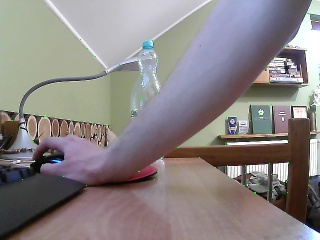

Avg times (ms): pre: 15.098314 | net: 25.390127 | post: 60.322595 | matching: 19.737798 | pose: 11.314906 | all: 131.863739 | matches: 108.369369


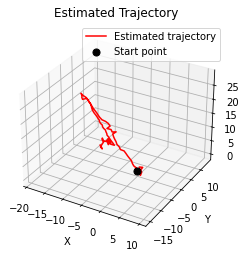

In [20]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera.")
    exit()
print("start")
last_scores = None
last_descriptors = None
pre_times = []
net_times = []
post_times = []
matching_times = []
pose_times = []
all_times = []
matches_list = []
matches = []

fx=517.3
fy= 516.5
cx=318.6
cy=255.3

t_start = np.zeros((3, 1))
start_R = np.eye(3)
r = R.from_matrix(start_R)
angles = r.as_euler('zyx', degrees=True)  # yaw, pitch, roll

R_list = [angles]
total_t = np.zeros((3, 1))
total_R = np.eye(3) 

trajectory = [t_start.flatten().tolist()]
try:
    while True:
        start_time = time.perf_counter()
        ret, img = cap.read()
        if not ret:
            print("Failed to read frame from the camera.")
            break    
        img = cv2.resize(img, image_size)

        img_preprocessed = img.mean(-1) / 255
        time1 = time.perf_counter()

        y_pred = net(img_preprocessed)
        time2 = time.perf_counter()
        scores, descriptors = post_processing(y_pred[0][0], y_pred[1][0])
        time3 = time.perf_counter()
        maching_time = time.perf_counter()

        if last_descriptors is not None:
            matches, k1, k2 = match_points(scores, descriptors, last_scores, last_descriptors)

            for match in matches:
                pt1 = tuple(map(int, k1[match.queryIdx].pt))
                pt2 = tuple(map(int, k2[match.trainIdx].pt))
                cv2.arrowedLine(img, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)
            maching_time = time.perf_counter()
            pts1 = np.float32([k1[match.queryIdx].pt for match in matches])  # shape (N, 2)
            pts2 = np.float32([k2[match.trainIdx].pt for match in matches])  # shape (N, 2)

            #pose estimation
            total_R, total_t, result, R_diff = pose_estimation(pts2, pts1, total_t, total_R, 1, focal=fx, pp=(cx, cy))

            r_global = start_R.dot(total_R)
            r = R.from_matrix(r_global)
            angles = r.as_euler('zyx', degrees=True)  # yaw, pitch, roll
            R_list.append(angles)
            trac = start_R.dot(total_t) + t_start
            trajectory.append(trac.flatten().tolist())
        end_time = time.perf_counter()
        last_descriptors = descriptors
        last_scores = scores
        clear_output(wait=True)
        display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))
        execution_time = (end_time - start_time)
        pre_times.append(time1 - start_time)
        net_times.append(time2 - time1)
        post_times.append(time3-time2)
        matching_times.append(maching_time - time3)
        pose_times.append(end_time - maching_time)
        all_times.append(execution_time)
        matches_list.append(len(matches))
except:
    cap.release()
    cv2.destroyAllWindows()      
num_iterations = len(pre_times) - 1
avg_pre = sum(pre_times[1:]) / num_iterations * 1000
avg_net = sum(net_times[1:]) / num_iterations * 1000
avg_post = sum(post_times[1:]) / num_iterations * 1000
avg_matching = sum(matching_times[1:]) / num_iterations * 1000
avg_pose = sum(pose_times[1:]) / num_iterations * 1000
avg_all = sum(all_times[1:]) / num_iterations * 1000
avg_matches = sum(matches_list[1:]) / num_iterations


print(f"Avg times (ms): pre: {avg_pre:.6f} | net: {avg_net:.6f} | post: {avg_post:.6f} | matching: {avg_matching:.6f} | pose: {avg_pose:.6f} | all: {avg_all:.6f} | matches: {avg_matches:.6f}")
trajectory = np.array(trajectory)

tx_est, ty_est, tz_est = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(tx_est, ty_est, tz_est, label='Estimated trajectory', color='red')

ax.scatter(tx_est[0], ty_est[0], tz_est[0], color='black', marker='o', s=50, label='Start point')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Estimated Trajectory")

x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()

x_range = abs(x_limits[1] - x_limits[0])
y_range = abs(y_limits[1] - y_limits[0])
z_range = abs(z_limits[1] - z_limits[0])
max_range = max(x_range, y_range, z_range)

mid_x = np.mean(x_limits)
mid_y = np.mean(y_limits)
mid_z = np.mean(z_limits)

ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

ax.legend()
plt.show()